# Homework 2：

⾃动编码器模型（AE）；变分⾃动编码器模型（VAE）；条件变分⾃动编码器模型（Conditional VAE）

并将模型应⽤到MNIST 数据上对⼿写体数字进⾏降维、聚类、⽣成和指定⽣成⼯作。

## 内容导览
1. FC layer实现AE、VAE、CVAE & 画图展示、
   
- 1.1 AE、VAE、CVAE架构搭建
  - 1.1.1 通用部件Encoder & Decoder的实现
  - 1.1.2 基于通用部件的AE、VAE、CVAE实现
  
- 1.2模型训练
  - 1.2.1 损失函数
  - 1.2.2 训练
  - 1.2.3 预测
  - 1.2.4 数据准备
  - 1.2.5 main函数

2. 作业第一题 : FC
- 2.1 AE & PAC
  - (A)：相同隐向量⻓度下（尝试多个不同的隐向量⻓度），AE 和PCA 获得的重建图像质量（同时展示原图、AE 和PCA 重建图）
  - (B): ⽐较AE 和PCA 获得的隐向量能否区分不同⼿写体数字（⽤t-SNE 或UMAP 对获得的隐向量进⾏进⼀步降维，降成2 维，然后将每个数据点画到⼆维平⾯上，点的颜⾊根据数字true label 标注）；
  - (C): 对AE 和PCA 的隐向量进⾏聚类分析，将（B）中点的颜⾊⽤聚类得到的clsuter label 标注，从新⽣成图⽚。

- 2.2 VAE
  - (D) : 将VAE 模型得到的隐向量（均值向量）与上述中的AE 的隐向量 进⾏⽐较，具体执⾏上述的B 和C 操作，将PCA 替换成VAE，对⽐隐向量对不同数字的区分情况和聚类效果；
  - (E) : 尝试⽤VAE 为每⼀种⼿写体数字⽣成⼀张图⽚。

- 2.3 CVAE
  - (F) : ⽐较VAE 和CVAE 学得的隐向量，重复B、C 操作将⾥⾯的⽅法替换为VAE 和CVAE
  - (G) : 为每⼀个⼿写体数字⽣成⼀张图⽚。

1.  作业第二题：CNN
   

 
## 1. FC layer实现AE、VAE、CVAE & 画图展示

### 1.1 AE、VAE、CVAE架构搭建
 
#### 1.1.1 通用部件Encoder & Decoder的实现


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder实现

condition_size = 10 #10个数字，用一个10维向量作为CVAE的条件（0-9十个数字，依label给出one-hot编码）
ignore = True # 是否需要忽略训练信息的输出

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

def onehot(label): # CVAE为了要和input（1*28*28）可以concatenate，需要扩展成3维的(后续还有batch_size就变成三维)
    label = label.unsqueeze(1)
    label = label.unsqueeze(2)
    #print(label.size(0))
    exp_vec = torch.zeros(label.size(0), 1, condition_size).to(device)
    # 【新创建的，和已在cuda上tensor无关，不知道应该放在哪里！！！】
    exp_vec.scatter_(2, label, 1) # 根据label，对exp_vec进行操作，填写到维度为1的对应位置
    return exp_vec

class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_size, latent_size, arch="AE", layer="FC",**kwargs) -> None:
        super(Encoder, self).__init__()
        self.arch = arch
        if layer == "FC":
            self.mu = nn.Sequential(nn.Linear(x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, latent_size),)
            if self.arch == "VAE":  # 若encoder返回的是均值与标准差(VAE、CVAE), 需要额外生成mu和sigma（两架构可以一样）
                self.sigma = nn.Sequential(nn.Linear(x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, latent_size),)

            elif self.arch == "CVAE":
                self.mu = nn.Sequential(nn.Linear(x_dim + condition_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, latent_size),)
                self.sigma = nn.Sequential(nn.Linear(x_dim + condition_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, latent_size),)
        
            elif self.arch == "PCA":
                self.mu = nn.Linear(x_dim,latent_size)# 根据PCA最优解，不设置偏置项
        elif layer == "CNN":
            self.mu = nn.Sequential(nn.Linear(x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, latent_size),)
            """
            net = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=9, padding=0), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
    nn.Conv2d(32, 64, kernel_size=5, padding=0), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
    nn.Conv2d(64, 64, kernel_size=5, padding=0), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
    nn.Flatten(),
    nn.Linear(12*12*64, 3), nn.ReLU(),# 一层FC网络，3个神经元，以ReLU()作为激励函数
)
            """



    def forward(self, xs, label=None):# 只有CVAE才会传入label，xs是输入的图片，784*1*batchsize
        # 实现编码器的forward过程，arch架构的不同取值意味着我们需要不同输出的encoder

        if self.arch == "AE" or self.arch == "PCA":
            output = self.mu(xs) # AE的输出，只有一个code
        elif self.arch == "VAE":# VAE的输出，有mu和sigma两个输出
            mu = self.mu(xs)
            sigma = self.sigma(xs)
            output = (mu,sigma)
        elif self.arch == "CVAE": # CVAE的输出，有mu和sigma两个，但是输入还有希望生成数据的label！先扩展、再concatenate起来
            label = onehot(label)
            # print("dim_image",xs.shape)
            # print("label_image",label.shape)
            xs= torch.cat((xs, label), dim=-1)
            # xs = xs.to(device)     # Bug：不用等号赋值，就没办法移动到cuda上！
            mu = self.mu(xs)
            sigma = self.sigma(xs)
            output = (mu,sigma)
        return output

# Decoder的实现
# 不同的自编码器可能需要不同的输入, 借助**kwargs来处理.
# Review：**收集所有未匹配的关键字参数组成一个dict对象，局部变量kwargs指向此dict对象
# 对于AE的情况, 只需要zs作为输入即可,
# 对于VAE,CVAE的情况, 我们可能需要code服从分布的均值与方差(对于CVAE, 还需要类别的指示变量)

# 在实现遇到迷茫的时候, 不妨考虑具体的自编码器类需要什么样的encoder, decoder.
class Decoder(nn.Module):
    def __init__(self, x_dim, hidden_size, latent_size, arch="AE", **kwargs) -> None:
        super(Decoder, self).__init__()
        self.arch = arch
        if self.arch == "AE":
            self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size), nn.ReLU(), 
            nn.Linear(hidden_size, x_dim),)
        elif self.arch == "VAE": # 需要传入encoder的均值和方差 
            self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size), nn.ReLU(), 
            nn.Linear(hidden_size, x_dim),)
        elif self.arch == "CVAE":
            self.decoder = nn.Sequential(nn.Linear(latent_size+condition_size, hidden_size), nn.ReLU(), 
            nn.Linear(hidden_size, x_dim),)  
        elif self.arch == "PCA":
            self.decoder = nn.Linear(latent_size,x_dim)

    def forward(self, zs,label=None, **otherinputs): # 【【此时的zs已经是经过处理过的，已经是N(mu,sigma^2)中sample出来的值了】】
        # 实现decoder的decode部分,此时就假定直接输出图片了，不再生成mu和sigma再sample
        if self.arch == "AE":
            output = self.decoder(zs)
        elif self.arch == "VAE":
            output = self.decoder(zs)
        elif self.arch == "CVAE":
            label = onehot(label)
            zs = torch.cat((zs, label), dim=-1)
            output = self.decoder(zs)
        elif self.arch == "PCA":
            output = self.decoder(zs)
        return output

#### 1.1.2 基于通用部件的AE、VAE、CVAE实现

In [44]:
class PCA(nn.Module):
    def __init__(self, encoder, decoder, **kwargs) -> None:
        super(PCA, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, need_code=False):
        z = self.encoder(x)
        #print("PCA_code_shape",z.shape)
        if need_code==True:
            return self.decoder(z), z
        return self.decoder(z)

class AE(nn.Module):
    def __init__(self, encoder, decoder, **kwargs) -> None:
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, need_code=False):
        z = self.encoder(x)
        if need_code == True:
            return self.decoder(z), z
        return self.decoder(z)

class VAE(nn.Module): # 要同时返回中间参数mu和sigma的，用于后续计算kl loss
    def __init__(self,encoder,decoder,**kwargs) -> None:
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self,x):
        mu,sigma = self.encoder(x) # 【encoder的forward函数返回了两个参数！！！】
        # epsilon = torch.randn(mu) # 生成了很多个正态分布！！！mu是一个latent_size大小的，每一个分量是一个正态参数
        # z = mu + epsilon*sigma
        # 【更优！加入随机噪声！！！对encoder输出进行简单处理，且保证是正数！】
        std = torch.exp(0.5 * sigma)
        epsilon = torch.randn_like(std)
        z = epsilon * std + mu
        self.mu = mu
        self.sigma = sigma
        return mu, sigma, self.decoder(z)

    def generate(self,new_code):
        new_code = new_code.to(device) 
        std = torch.exp(0.5 * self.sigma)
        epsilon = torch.randn_like(std)
        new_code = epsilon * std + self.mu
        return self.decoder(new_code) # 【假设此时new_code是N（0,1）中拿出来的】


class CVAE(nn.Module):
    def __init__(self,encoder,decoder,**kwargs) -> None:
        super(CVAE, self).__init__()
        self.encoder = encoder #【【【小心！传入时arch必须设定成 “CVAE”】】】
        self.decoder = decoder

    def forward(self,x,label):# label必须传入
        mu,sigma =self.encoder(x,label)# 【forward返回两参数，其中input已经concatenate了】
        std = torch.exp(0.5 * sigma)
        epsilon = torch.randn_like(std)
        z = epsilon * std + mu
        self.mu = mu
        self.sigma = sigma
        return mu, sigma, self.decoder(z,label) # decoder中再合并

    def generate(self,new_code,label):
        new_code = new_code.to(device)
        label = label.to(device)
        new_code = new_code.to(device) 
        std = torch.exp(0.5 * self.sigma)
        epsilon = torch.randn_like(std)
        new_code = epsilon * std + self.mu
        return self.decoder(new_code,label) # 【假设此时new_code是N（0,1）中拿出来的】





# 1.2 模型训练

## 1.2.1 损失函数
其中值得注意的是VAE及CVAE为了防止过拟合而引入的KL散度，作为损失函数的衡量标准之一
$$KL(\mathcal{N}(\mu,\sigma ^2)||\mathcal{N}(0,1) ) = -\frac{1}{2}(\log (\sigma ^2)-\sigma ^2-\mu^2+1) $$

In [45]:
# 训练中损失函数
# AE：MSE
# VAE & CVAE：KL loss + MSE 

# 【可调节超参数：kl散度在epoch增加后所占loss的权重】
aging_rate = 0.3

class Loss(nn.Module):
    def __init__(self, arch="AE", choice="BCE", **kwargs) -> None:
        super().__init__()
        self.arch = arch
        self.choice = choice
    def recon_loss(self, x, x_): # 重构损失
        if self.choice == "L1": # L1
            instance = nn.L1Loss()  # 【【BUG？必须选择这个？】】
            loss = instance(x, x_) # 【【类的实例化（上一行） 和 实例的调用（本行）不能放在一起！！！】】
        else: # BCE
            loss = F.binary_cross_entropy(F.sigmoid(x_),F.sigmoid(x), reduction='sum')
        return loss

    def kl_div(self, mu,sigma): # KL loss
        return  -0.5 * torch.mean(torch.log(sigma.pow(2)) - sigma.pow(2) - mu.pow(2) + 1)

    def forward(self, x, x_, mu=None, sigma=None, **otherinputs):# loss的计算
        loss = Loss.recon_loss(self,x,x_)# 可选choice = "L1"
        if self.arch == "AE" or self.arch == "PCA":
            total_loss = loss
        elif self.arch == "VAE" or self.arch=="CVAE":
            kl_loss = Loss.kl_div(self,mu,sigma)
            total_loss = loss + kl_loss
        return total_loss

### 1.2.2 训练

In [46]:
# 超参数，可以在x.reshape中调整！
from tensorboardX import SummaryWriter

batch_size = 128

def train_epoch(model, train_loader, loss, optimizer, epoch, epoch_num, arch):
    """
    main中需要传入的参数
    model：是AE、VAE、CVAE的model（类的实例）
    train_loader：main中导入的minist数据集
    loss：定义的损失函数类的实例中的函数
    optimizer：torch中自带的优化器
    epoch：当前迭代优化轮数
    epoch_num：一共迭代优化的轮数
    arch：当前选择的model的名字（字符串）
    """
    log = []
    model.train() # 调用继承的父类nn.Module的方法，所有子模块调整为训练模式
    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        # 【【【只需要把所有训练数据（x，y）放到cuda上就可以啦！！！其他的自动依据device判断位置】】】
        y = y.to(device)
        # Review：enumerate把可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
        # 既可以直接访问该对象，又可以通过索引来访问！
        x = x.reshape(128, 1, -1)  
        # 生成(128,1,784)，原来batch_size对应的特征矩阵是128*1*28*28，
        # 其实四维和三维的效果一样，28*28每个pixel都是要作为一个neuron作为input的！
        if arch == "AE" or arch == "PCA":
            # x_ = model.forward(x)
            x_ = model(x)     
            """
            自动调用 forward 函数原因分析：
            利用Python的语言特性，y = model(x)是调用了对象model的__call__方法，
            而nn.Module把__call__方法实现为类对象的forward函数，
            所以任意继承了nn.Module的类对象都可以这样简写来调用forward函数。
            """
            loss_num = loss(x, x_) # 同理，自动调用loss中的forward方法！！！
        elif  arch == "VAE":
            # mu, log_var, x_= model.forward(x)
            mu, sigma, x_= model(x)
            loss_num = loss(x, x_,mu,sigma)
        elif  arch == "CVAE":
            # mu, log_var, x_ = model.forward(x,y)# y是train data的真实label
            mu, sigma, x_ = model(x,y)# y是train data的真实label
            loss_num = loss(x, x_,mu,sigma)

        train_loss += loss_num # 在此处计算总loss
        optimizer.zero_grad() # 在计算本batch_size的梯度之前，把之前的梯度清空,不做积累。只针对每一个batch中loss回溯
        loss_num.backward()
        optimizer.step()
        if not ignore:
            if i % 50 == 0: # 训练过程中的标记
                print('Train Epoch:',epoch, i * len(x), len(train_loader.dataset),
                       100. * i / len(train_loader),"Loss: ",loss_num.item())
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch,
            train_loss * 128 / len(train_loader.dataset)))
    log.append((epoch,train_loss))
    return log
    """
    tb_writer = SummaryWriter()  # 创建SummartWriter
    tags = ["data/train_loss", "data/learning_rate"]      # 绘图的tags
    tb_writer.add_scalars(tags[0], {'train_loss': train_loss}, epoch) # 绘制train和val的loss，放在一个图上
    tb_writer.add_scalar(tags[2], optimizer.param_groups[0]["lr"], epoch)           # 绘制学习率曲线，放在一个图上
    """

### 1.2.3 预测

In [47]:
import os
from torchvision.utils import make_grid, save_image
import matplotlib as plt
import numpy as np
# make_grid是张量可视化的包！！！
# 可以协同plt一起共同操作，可以操作一下！！！
from tensorboardX import SummaryWriter

#need_code=False就是不需要返回值
def evaluate_epoch(model, test_loader, loss, epoch, epoch_num, arch, need_code=False):
    model.eval() # 所有子模块调整为评估模式
    test_loss = 0
    log = []
    code_with_label=[]# code 和 label

    with torch.no_grad(): # 评估过程，不用调整参数=不用梯度下降》》在此作用域中不会构建计算图
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)#【必须要放！】
            x = x.reshape(128, 1, -1) # 同理，特征矩阵的三维处理

            if arch == "AE" or arch == "PCA":
                if need_code == True:
                    x_,code = model(x,need_code=True)
                    # print("============code.shape=========",code.shape)
                    code_with_label.append((code,y))
                x_ = model(x)
                loss_num = loss(x, x_)
                test_loss += loss_num.item()

                # 保存一些重构出来的图像
                with torch.no_grad():
                    if i % 30 == 0:
                        # 对照：保留原始图像数据，每30个保留一个

                        # 测试：对原图的重现功能
                        if not os.path.exists(f"results_AE_PCA/{arch}/epoch_{epoch}"):
                            os.makedirs(f"results_AE_PCA/{arch}/epoch_{epoch}")
                        save_x_ = x_.reshape(-1, 1, 28, 28)[:16]
                        save_x_ = make_grid(save_x_, 8, 0)
                        save_image(save_x_, os.path.join(f"results_AE_PCA/{arch}/epoch_{epoch}/batch_{i}.png"))
                

                        if not os.path.exists(f"results_AE_PCA/{arch}/initial_data"):
                            os.makedirs(f"results_AE_PCA/{arch}/initial_data")
                        save_x = x.reshape(-1,1, 28, 28)[:16]#dim=0是batch_size，后面就是一个个图片的三维大小啦
                        save_x = make_grid(save_x,8,0) # 【生成图片，可以后续使用plt在notebook展现
                        save_image(save_x,os.path.join(f"results_AE_PCA/{arch}/initial_data/batch_{i}.png"))
                        

            # 只有VAE和CVAE有图像生成功能，AE就不用考虑啦！
            elif arch == "VAE":
                mu, sigma, x_ = model(x)
                if need_code==True:
                    code_with_label.append((mu,y))
                loss_num = loss(x, x_, mu, sigma)
                test_loss += loss_num.item()
                z = torch.randn(128,1,10)
                # 测试：随机向量生成图片功能
                sample = model.generate(z)
                sample = sample.reshape(-1, 1, 28, 28)[:32]
                #print(z[0],sample[0])
                if not os.path.exists(f"results_VAE"):
                    os.makedirs(f"results_VAE")
                save_image(
                    sample,
                    os.path.join(f"results_VAE/epoch_{epoch}.png")
                )
                # 【生成图片，可以后续使用plt在notebook展现】

            elif arch == "CVAE":
                mu, sigma, x_ = model(x,y)
                if need_code==True:
                    code_with_label.append((mu,y))
                loss_num = loss(x, x_, mu, sigma)
                test_loss += loss_num.item()
                z = torch.randn(128,1,10)
                # 测试：随机向量生成图片功能
                sample = model.generate(z,y)
                sample = sample.reshape(-1, 1, 28, 28)[:32]
                #print(z[0],sample[0])
                if not os.path.exists(f"results_CVAE"):
                    os.makedirs(f"results_CVAE")
                save_image(
                    sample,
                    os.path.join(f"results_CVAE/epoch_{epoch}.png")
                )
                # 【生成图片，可以后续使用plt在notebook展现】

    test_loss *= 128
    test_loss /= len(test_loader.dataset)
    if not ignore:
        print('====> Test set loss: {:.4f}'.format(test_loss))
    log.append((epoch,test_loss))
    if need_code == True:
        return code_with_label, log
    else:
        return log
    """
tb_writer = SummaryWriter()  # 创建SummartWriter

    tags = [ "data/test_loss", "data/learning_rate"]      # 绘图的tags
    tb_writer.add_scalars(tags[0], {'testloss':test_loss }, epoch) # 绘制train和val的loss，放在一个图上

"""

### 1.2.4 数据准备

In [48]:
# 数据集格式：28*28的灰度图像，channel = 1
# 超参数 batch_size = 128
import torch.utils.data as td
import torchvision.datasets.mnist as mnist
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def get_data(wh_train=True, batch_size=128):
    dataset = mnist.MNIST(
        root="./data",
        train=wh_train,
        download=True,
        transform=transforms.Compose(
            [
                #transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize([0.1307,], [0.3081,],),
            ]
        ),
    )
    return td.DataLoader(dataset, batch_size=batch_size,drop_last=True,)



### 1.2.5 通用main函数框架（传入args用于不同任务）

In [49]:
import matplotlib
import argparse
import logging


def main(args):
    encoder_args = {
        "x_dim": args.x_dim,
        "hidden_size": args.hidden_size,
        "latent_size": args.latent_size,
        "arch": args.type,
    }
    encoder = Encoder(**encoder_args)
    decoder = Decoder(**encoder_args)
    ae = {"AE": AE, "VAE": VAE, "CVAE": CVAE, "PCA":PCA}

    auto_encoder = ae[args.type](encoder, decoder) #【巧！通过字典的索引直接可以用此类来创建实例啦！】

    auto_encoder.to(device)
    # 优化器选择
    # optimizer = torch.optim.SGD(auto_encoder.parameters(), lr=0.01)
    optimizer =torch.optim.Adam(auto_encoder.parameters(), lr=0.001)
    # class中用nn定义的神经网络中参数，可认为是自动加上了nn.Parameters()的处理，参数会被加入！
    train_loader = get_data(wh_train=True, batch_size=args.batch_size)
    test_loader = get_data(wh_train=False, batch_size=args.batch_size)
    loss = Loss(args.type,choice="BCE")#【不加choice，就默认用BCE.可以选择choice="L1"】

# TODO：可以每个损失函数，分别给一个文件夹存放出来的图片呢！！！

    code_with_label=[]
    train_loss=[]
    evaluate_loss=[]
    #print("args.need_code",args.need_code)
    for epoch in range(args.epoch_num):
        if not ignore:
            print("\n epoch:", epoch)
        loss_l = train_epoch(model=auto_encoder, loss=loss, train_loader=train_loader,
                    optimizer=optimizer, epoch=epoch, epoch_num=args.epoch_num, arch=args.type)
        train_loss += loss_l
        if args.need_code == True:
            temp,loss_l = evaluate_epoch(model=auto_encoder, test_loader=test_loader, loss=loss,
                   epoch=epoch, epoch_num=args.epoch_num, arch=args.type, need_code=True)
            code_with_label = temp
            evaluate_loss += loss_l
        else:
            loss_l = evaluate_epoch(model=auto_encoder, test_loader=test_loader, loss=loss,
                   epoch=epoch, epoch_num=args.epoch_num, arch=args.type)
            evaluate_loss += loss_l
                

    x_t,y_t = zip(*train_loss)
    x_e,y_e = zip(*evaluate_loss)

    print("=================================================================")
    plt.figure(figsize=(3, 3))
    plt.plot(torch.tensor(x_t).cpu(), torch.tensor(y_t).cpu(), c="r", marker='D', markersize=5)
        #绘制坐标轴标签
    plt.xlabel("epch")
    plt.ylabel("train_loss")
    plt.show()

    plt.figure(figsize=(3, 3))
    plt.plot(torch.tensor(x_e).cpu(), torch.tensor(y_e).cpu(), c="r", marker='D', markersize=5)
    #绘制坐标轴标签
    plt.xlabel("epch")
    plt.ylabel("test_loss")
    plt.show()

    if args.need_code == True:
        return code_with_label
    else:
        return None


##  2. 作业第一题

###  (A)：相同隐向量（code）长度下（尝试多个不同的隐向量长度），AE 和PCA 获得的重建图像质量(同时展示原图、AE 和PCA 重建图)

c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\i

True


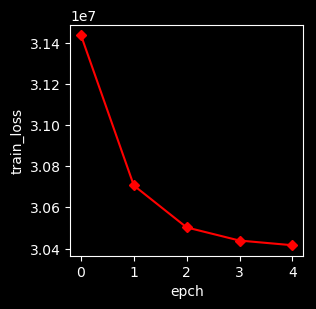

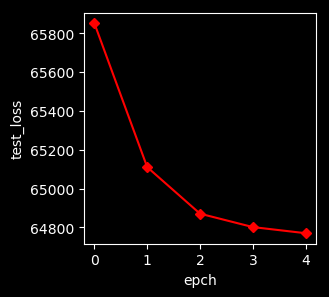

Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=False, type='PCA', x_dim=784)
Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=False, type='AE', x_dim=784)


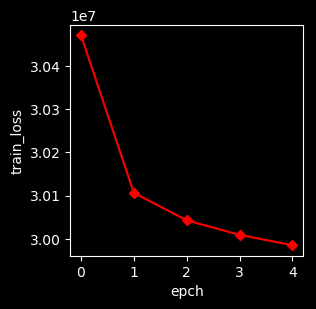

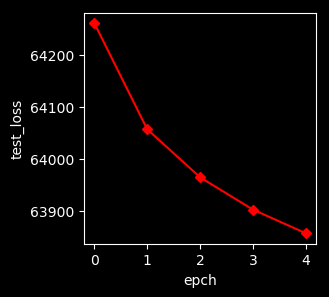

-----------------------------------------------------------------------------
image in max epoch: 5
PCA --- batch_ 0


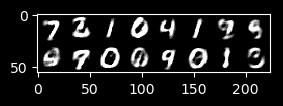

AE --- batch_ 0


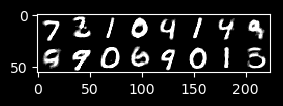

initial image --- batch_ 0


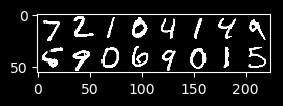

-----------------------------------------------------------------------------
PCA --- batch_ 30


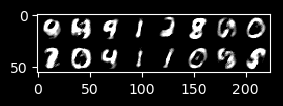

AE --- batch_ 30


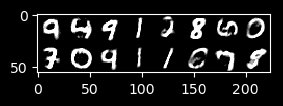

initial image --- batch_ 30


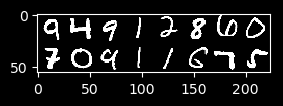

-----------------------------------------------------------------------------
PCA --- batch_ 60


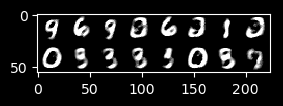

AE --- batch_ 60


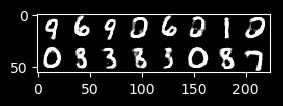

initial image --- batch_ 60


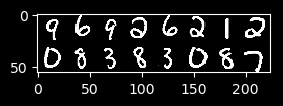

-----------------------------------------------------------------------------


In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 



# PCA训练结果
if __name__ == "__main__":   
    matplotlib.use('TkAgg')
    print(torch.cuda.is_available())
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="PCA", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)
    parser.add_argument("--need_code", default=False, type=bool)# 此时需要code
    # args = parser.parse_args()
    # 调用parser.parse_args()会读取系统参数：sys.argv[]，命令行调用时是正确参数，
    # 而在jupyter notebook中调用时，sys.argv的值为ipykrnel_launcher.py：

    # args = parser.parse_args(args=[])
    
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device("cpu")
    args.device = device
    main(args)
    print(args)

# AE训练结果
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="AE", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)   
    parser.add_argument("--need_code", default=False, type=bool)# 此时需要code
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.device = device
    print(args)
    main(args)
    

    print('-----------------------------------------------------------------------------')
    print("image in max epoch:",args.epoch_num)
    for idx in [0,30,60]:
        print("PCA --- batch_",idx)
        recons_path = f'./results_AE_PCA/PCA/epoch_2/batch_{idx}.png' 
        #【必须要带f，表示字符串中可以使用定义好的变量】
        Image = mpimg.imread(recons_path)
        plt.figure(figsize=(3, 4))
        plt.imshow(Image)
        plt.show()
        print("AE --- batch_",idx)
        recons_path = f'./results_AE_PCA/AE/epoch_2/batch_{idx}.png' 
        #【必须要带f，表示字符串中可以使用定义好的变量】
        Image = mpimg.imread(recons_path)
        plt.figure(figsize=(3, 4))
        plt.imshow(Image)
        plt.show()
        print("initial image --- batch_",idx)
        recons_path = f'./results_AE_PCA/PCA/initial_data/batch_{idx}.png'
        Image = mpimg.imread(recons_path)
        plt.figure(figsize=(3, 4))
        plt.imshow(Image)
        plt.show()
        print('-----------------------------------------------------------------------------')
        


### (B) : ⽐较AE 和PCA 获得的隐向量能否区分不同⼿写体数字（⽤t-SNE 或UMAP 对获得的隐向量进⾏进⼀步降维，降成2 维，然后将每个数据点画到⼆维平⾯上，点的颜⾊根据数字true label 标注）

c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\i

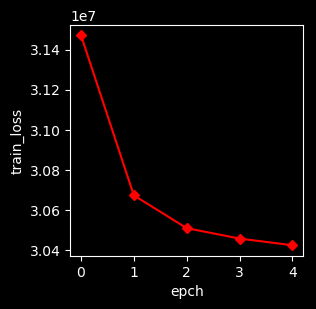

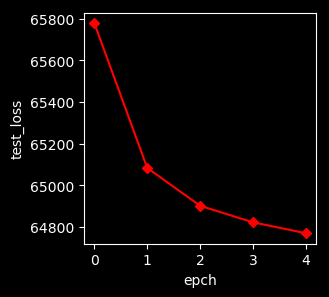

Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=True, type='PCA', x_dim=784)


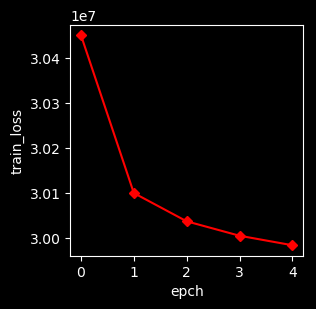

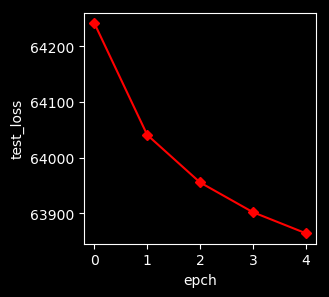

Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=True, type='AE', x_dim=784)


In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import argparse
import logging

# PCA训练结果
if __name__ == "__main__":   
    matplotlib.use('TkAgg')
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="PCA", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)
    parser.add_argument("--need_code", default=True, type=bool)# 此时需要code 
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.device = device
    code_with_label_PCA = main(args)
    print(args)
    code_PCA=[]
    label_PCA=[]
    for item in code_with_label_PCA:
        code_PCA.append(item[0])
        label_PCA.append(item[1])

# AE训练结果
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="AE", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)   
    parser.add_argument("--need_code", default=True, type=bool)# 此时需要code
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.device = device
    code_with_label_AE = main(args)
    print(args)
    code_AE=[]
    label_AE=[]
    for item in code_with_label_AE:
        code_AE.append(item[0])
        label_AE.append(item[1])

    


c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 20

PCA使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


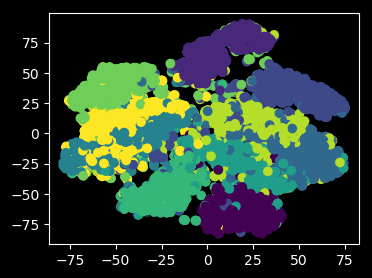

c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


AE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


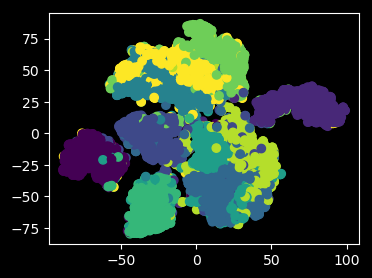

In [52]:

# 此时获得的code_PCA是一个batch中所有向量的code！一共234个batch
# 创建TSNE对象
tsne_PCA = TSNE(n_components=2)
    # 将高维数据降维到二维
data_code_PCA=[]
data_label_PCA=[]

for idx in range(1,len(code_PCA)):
    code_PCA[idx] = torch.tensor(code_PCA[idx]).cpu()
    label_PCA[idx] = torch.tensor(label_PCA[idx]).cpu()
    for num in range(0,128):
        data_code_PCA.append(list(code_PCA[idx][num][0]))
        # 【BUG！tsne是接受list类别的样本，不接受一维类别的tensor！】
        # print(code_PCA[idx][num][0].shape)
        # idx是选列表中第几个batch，num是128个哪个（dim=0），0是1个中哪个（dim=1）
        data_label_PCA.append(label_PCA[idx][num])
        
X_tsne_PCA = tsne_PCA.fit_transform(list(data_code_PCA))
    # 可视化降维结果
print("PCA使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_PCA[:, 0], X_tsne_PCA[:, 1], c = data_label_PCA)
plt.show()

    # 创建TSNE对象
tsne_AE = TSNE(n_components=2)

data_code_AE=[]
data_label_AE=[]


for idx in range(1,len(code_AE)):
    code_AE[idx] = torch.tensor(code_AE[idx]).cpu()
    label_AE[idx] = torch.tensor(label_AE[idx]).cpu()
    for num in range(0,128):
        data_code_AE.append(list(code_AE[idx][num][0]))
        # 【BUG！tsne是接受list类别的样本，不接受一维类别的tensor！】
        # print(code_PCA[idx][num][0].shape)
        # idx是选列表中第几个batch，num是128个哪个（dim=0），0是1个中哪个（dim=1）
        data_label_AE.append(label_AE[idx][num])
        
X_tsne_AE = tsne_AE.fit_transform(list(data_code_AE))
    # 可视化降维结果
print("AE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = data_label_AE)
plt.show()

# PCA和AE画图中每个数字所对应的颜色相同，通过参数c传入点的颜色


### (C) : 对AE 和PCA 的隐向量进⾏聚类分析，将（B）中点的颜色用聚类得到的clsuter label 标注，重新⽣成图⽚。

PCA用t-SNE降到2维，使用原label


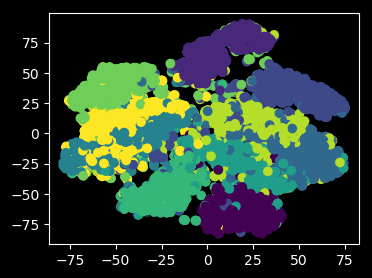

PCA用t-SNE降到2维，使用聚类label


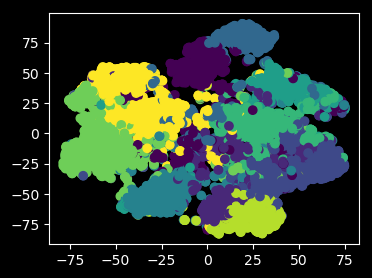

AE用t-SNE降到2维，使用原label


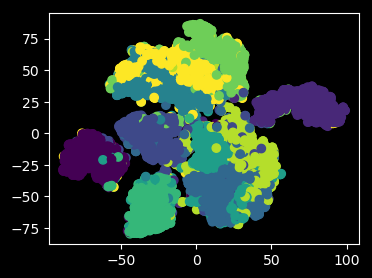

AE用t-SNE降到2维，使用聚类label


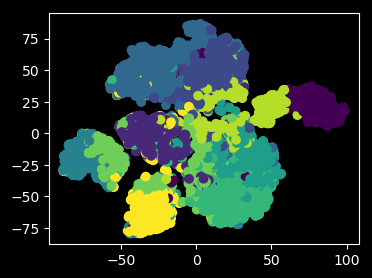

In [53]:
from sklearn.cluster import KMeans

# PCA原label和聚类后label对比
n_clusters = 10 # 0-9个label
# PCA聚类效果
X_PCA = data_code_PCA
cluster_PCA = KMeans(n_clusters=n_clusters, random_state=0).fit(X_PCA)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_PCA.labels_
print("PCA用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_PCA[:, 0], X_tsne_PCA[:, 1], c = data_label_PCA)
#print(data_label_PCA)
plt.show()

print("PCA用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_PCA[:, 0], X_tsne_PCA[:, 1], c = y_pred)
#print(y_pred)
plt.show()

X_AE = data_code_AE
cluster_AE = KMeans(n_clusters=n_clusters, random_state=0).fit(X_AE)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_AE.labels_
print("AE用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = data_label_AE)
#print(data_label_PCA)
plt.show()

print("AE用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = y_pred)
#print(y_pred)
plt.show()


#KMeans因为并不需要建立模型或者预测结果，因此我们只需要fit就能够得到聚类结果了
#KMeans也有接口predict和fit_predict，表示学习数据X并对X的类进行预测
#但所得到的结果和我们不调用predict，直接fit之后调用属性labels一模一样
# 少量的数据就可以帮助我们确定质心了
# 剩下的数据的聚类结果，使用predict来调用
#【使用部分聚类，生成质心，剩下的数据依据质心来聚类就好啦】
# cluster_smallsub_PCA = KMeans(n_clusters=n_clusters, random_state=0).fit(X_PCA[:200])
# y_pred_ = cluster_smallsub_PCA.predict(X_PCA)
#重要属性cluster_centers_，查看质心，是一个10*10的坐标

## 2.2 VAE & AE

### (D) : 将VAE 模型得到的隐向量（均值向量）与上述中的AE 的隐向量 进⾏⽐较，具体执⾏上述的B、C 操作

此时为了代码复用性提升，三个任务共用一个main函数框架

c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\i

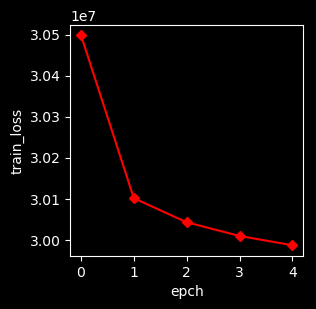

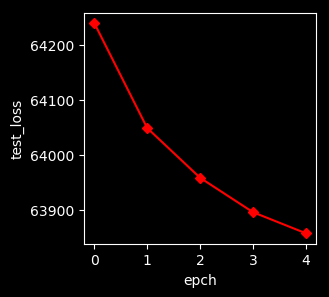

Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=True, ran_code=tensor([[[-1.1352,  0.8233, -0.8975,  ..., -0.9524, -0.5988, -0.6412]],

        [[ 0.1078,  2.3021,  0.5232,  ..., -1.6909,  0.3899,  0.2001]],

        [[ 0.4648,  0.2970,  0.6138,  ..., -0.5899,  0.0283, -0.7837]],

        ...,

        [[ 1.0428,  0.6960,  0.2186,  ...,  0.3832, -2.0078,  0.5838]],

        [[-1.1046,  0.6017,  0.1423,  ...,  0.8136,  0.1189,  0.2359]],

        [[-0.7981, -0.4541,  1.0444,  ...,  0.7750,  2.5696,  0.2797]]]), type='VAE', x_dim=784)


In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import argparse
import logging

# VAE训练结果
if __name__ == "__main__":   
    matplotlib.use('TkAgg')
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="VAE", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)
    parser.add_argument("--need_code", default=True, type=bool)# 此时需要code 
    ran_code = torch.randn(128,1,10)
    parser.add_argument("--ran_code",default=ran_code,type=list)
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.device = device
    code_with_label_VAE = main(args)
    print(args)
    code_VAE=[]
    label_VAE=[]
    for item in code_with_label_VAE:
        code_VAE.append(item[0])
        label_VAE.append(item[1])


c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 20

-------------------------VAE & AE 重做task B--------------------------------
VAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


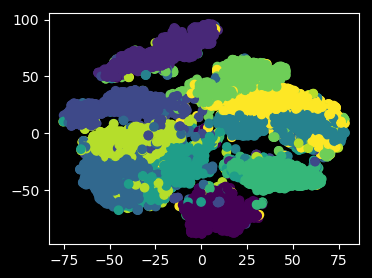

AE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


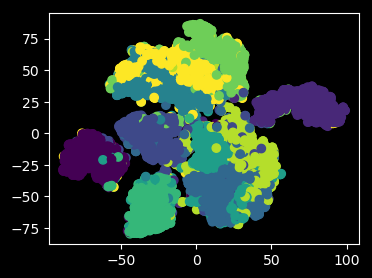

In [55]:
# 【重做B任务】

tsne_VAE = TSNE(n_components=2)
    # 将高维数据降维到二维
data_code_VAE=[]
data_label_VAE=[]

for idx in range(1,len(code_VAE)):
    code_VAE[idx] = torch.tensor(code_VAE[idx]).cpu()
    label_VAE[idx] = torch.tensor(label_VAE[idx]).cpu()
    for num in range(0,128):
        data_code_VAE.append(list(code_VAE[idx][num][0]))
        # 【BUG！tsne是接受list类别的样本，不接受一维类别的tensor！】
        # print(code_PCA[idx][num][0].shape)
        # idx是选列表中第几个batch，num是128个哪个（dim=0），0是1个中哪个（dim=1）
        data_label_VAE.append(label_VAE[idx][num])
        
X_tsne_VAE = tsne_VAE.fit_transform(list(data_code_VAE))
    # 可视化降维结果
print("-------------------------VAE & AE 重做task B--------------------------------")
print("VAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = data_label_VAE)
plt.show()


    # 可视化降维结果
print("AE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = data_label_AE)
plt.show()


-------------------------VAE & AE 重做task C--------------------------------
VAE用t-SNE降到2维，使用原label


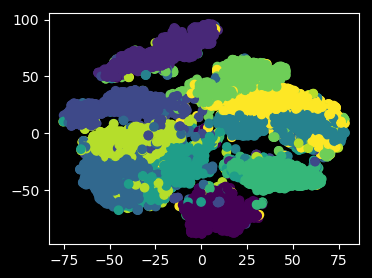

VAE用t-SNE降到2维，使用聚类label


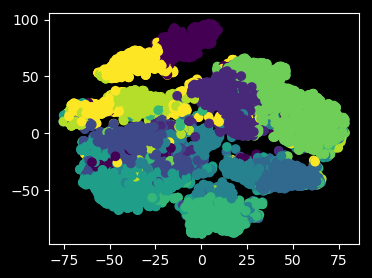

AE用t-SNE降到2维，使用原label


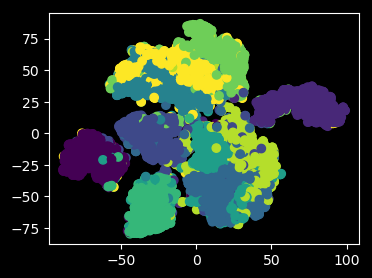

AE用t-SNE降到2维，使用聚类label


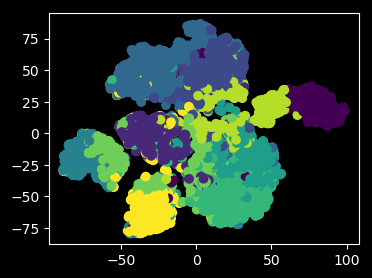

In [56]:
#【C任务】
print("-------------------------VAE & AE 重做task C--------------------------------")
# PCA原label和聚类后label对比
n_clusters = 10 # 0-9个label
# PCA聚类效果
X_VAE = data_code_VAE
cluster_VAE = KMeans(n_clusters=n_clusters, random_state=0).fit(X_VAE)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_VAE.labels_
print("VAE用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = data_label_VAE)
#print(data_label_PCA)
plt.show()

print("VAE用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = y_pred)
#print(y_pred)
plt.show()

X_AE = data_code_AE
cluster_AE = KMeans(n_clusters=n_clusters, random_state=0).fit(X_AE)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_AE.labels_
print("AE用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = data_label_AE)
#print(data_label_PCA)
plt.show()

print("AE用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_AE[:, 0], X_tsne_AE[:, 1], c = y_pred)
#print(y_pred)
plt.show()

### (E) : 尝试⽤VAE 为每⼀种⼿写体数字⽣成⼀张图⽚。（对Decoder的输入进行sample，3个epoch，每次sample128*1*10的随机code给decoder）

-------------------------VAE 新做task E，生成随机sample的code对应图像--------------------------------
VAE --- epoch_ 0


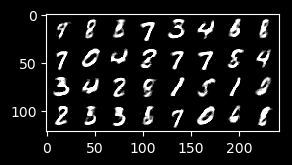

-----------------------------------------------------------------------------
VAE --- epoch_ 1


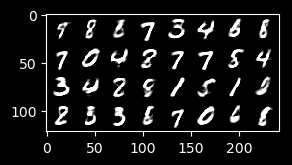

-----------------------------------------------------------------------------
VAE --- epoch_ 2


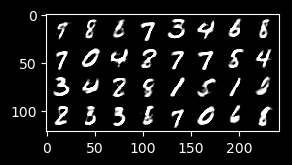

-----------------------------------------------------------------------------


In [57]:

#【E任务】
print("-------------------------VAE 新做task E，生成随机sample的code对应图像--------------------------------")
for idx in [0,1,2]:
    print("VAE --- epoch_",idx)
    recons_path = f'./results_VAE/epoch_{idx}.png' 
    #【必须要带f，表示字符串中可以使用定义好的变量】
    Image = mpimg.imread(recons_path)
    plt.figure(figsize=(3, 4))
    plt.imshow(Image)
    plt.show()
    print('-----------------------------------------------------------------------------')


### (F) : 将CVAE 模型得到的隐向量（均值向量）与上述中的VAE 的隐向量 进⾏⽐较，具体执⾏上述的B、C 操作

此时为了代码复用性提升，三个任务共用一个main函数框架

c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\i

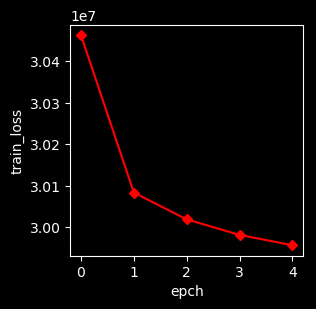

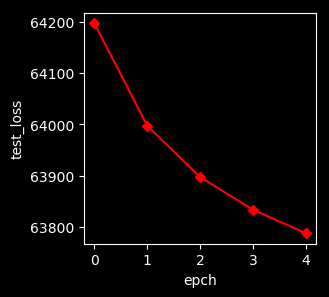

Namespace(batch_size=128, device=device(type='cuda'), epoch_num=5, hidden_size=128, latent_size=10, need_code=True, ran_code=tensor([[[ 0.8390, -0.9036, -0.9392,  ...,  0.6736, -0.2782,  0.7721]],

        [[ 1.4734, -0.3983, -1.0854,  ...,  0.0587, -1.5274, -2.2458]],

        [[-0.3926,  1.7981, -0.8105,  ...,  1.4578, -0.8140,  0.5377]],

        ...,

        [[ 0.8399,  0.8169,  0.1730,  ...,  0.8761, -0.2415, -1.1905]],

        [[-2.0588, -1.3138, -0.4091,  ...,  1.1529, -0.6878,  0.7572]],

        [[ 0.0424, -0.1528, -0.9513,  ...,  0.6678,  0.9586,  0.9234]]]), type='CVAE', x_dim=784)


In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import argparse
import logging

# CVAE训练结果
if __name__ == "__main__":   
    matplotlib.use('TkAgg')
    parser = argparse.ArgumentParser()
    parser.add_argument("--type", default="CVAE", choices=["AE", "VAE", "CVAE","PCA"])
    parser.add_argument("--x_dim", default=784, type=int)  # 28 x 28 的像素展开为一个一维的行向量，每行代表一个图片
    parser.add_argument("--latent_size", default=10, type=int)  # 输出层大小，即服从高斯分布的隐含变量的维度。
    parser.add_argument("--hidden_size", default=128, type=int)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--epoch_num", default=5, type=int)
    parser.add_argument("--need_code", default=True, type=bool)# 此时需要code 
    ran_code = torch.randn(128,1,10)
    parser.add_argument("--ran_code",default=ran_code,type=int)
    args = parser.parse_known_args()[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.device = device
    code_with_label_CVAE = main(args)
    print(args)
    code_CVAE=[]
    label_CVAE=[]
    for item in code_with_label_CVAE:
        code_CVAE.append(item[0])
        label_CVAE.append(item[1])


c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\86152\anaconda3\envs\com_torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 20

-------------------------CVAE & VAE 重做task B--------------------------------
CVAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


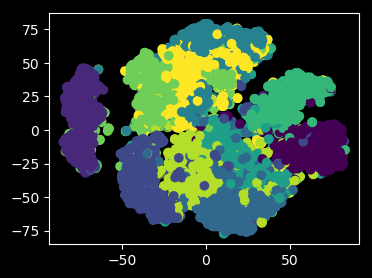

VAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下


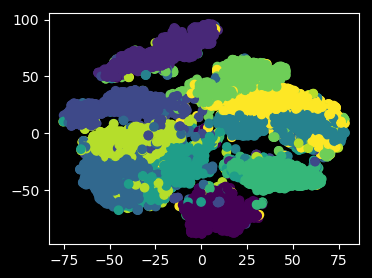

In [59]:
# 【重做B任务】

tsne_CVAE = TSNE(n_components=2)
    # 将高维数据降维到二维
data_code_CVAE=[]
data_label_CVAE=[]

for idx in range(1,len(code_VAE)):
    code_CVAE[idx] = torch.tensor(code_CVAE[idx]).cpu()
    label_CVAE[idx] = torch.tensor(label_CVAE[idx]).cpu()
    for num in range(0,128):
        data_code_CVAE.append(list(code_CVAE[idx][num][0]))
        # 【BUG！tsne是接受list类别的样本，不接受一维类别的tensor！】
        # print(code_PCA[idx][num][0].shape)
        # idx是选列表中第几个batch，num是128个哪个（dim=0），0是1个中哪个（dim=1）
        data_label_CVAE.append(label_CVAE[idx][num])
        
X_tsne_CVAE = tsne_CVAE.fit_transform(list(data_code_CVAE))
    # 可视化降维结果
print("-------------------------CVAE & VAE 重做task B--------------------------------")
print("CVAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_CVAE[:, 0], X_tsne_CVAE[:, 1], c = data_label_CVAE)
plt.show()


    # 可视化降维结果
print("VAE使用t-SNE,把10维的隐变量降维到2维后，样本点绘制如下")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = data_label_VAE)
plt.show()


-------------------------CVAE & VAE 重做task C--------------------------------
CVAE用t-SNE降到2维，使用原label


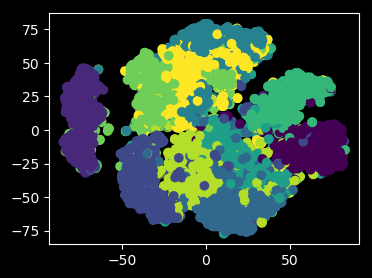

CVAE用t-SNE降到2维，使用聚类label


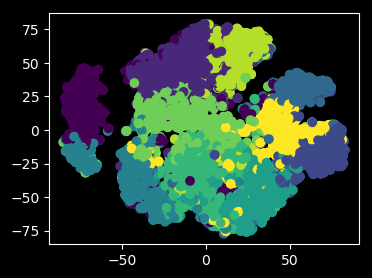

VAE用t-SNE降到2维，使用原label


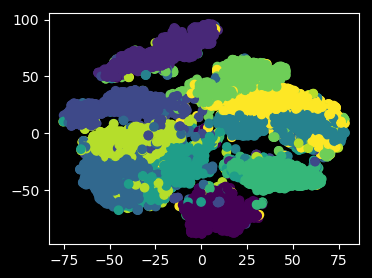

VAE用t-SNE降到2维，使用聚类label


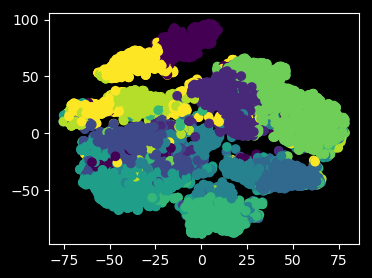

In [60]:
#【C任务】
print("-------------------------CVAE & VAE 重做task C--------------------------------")
# PCA原label和聚类后label对比
n_clusters = 10 # 0-9个label
# PCA聚类效果
X_CVAE = data_code_CVAE
cluster_CVAE = KMeans(n_clusters=n_clusters, random_state=0).fit(X_CVAE)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_CVAE.labels_
print("CVAE用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_CVAE[:, 0], X_tsne_CVAE[:, 1], c = data_label_CVAE)
#print(data_label_PCA)
plt.show()

print("CVAE用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_CVAE[:, 0], X_tsne_CVAE[:, 1], c = y_pred)
#print(y_pred)
plt.show()

X_VAE = data_code_VAE
cluster_VAE = KMeans(n_clusters=n_clusters, random_state=0).fit(X_VAE)
# 重要属性labels_，查看聚好的类别，每个样本所对应的簇
# 使用全部数据来聚类】
y_pred = cluster_VAE.labels_
print("VAE用t-SNE降到2维，使用原label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = data_label_VAE)
#print(data_label_PCA)
plt.show()

print("VAE用t-SNE降到2维，使用聚类label")
plt.figure(figsize=(4, 3))
plt.scatter(X_tsne_VAE[:, 0], X_tsne_VAE[:, 1], c = y_pred)
#print(y_pred)
plt.show()

### (G) : 尝试⽤CVAE 为每⼀种⼿写体数字⽣成⼀张图⽚。（对Decoder的输入进行sample，3个epoch，每次sample128*1*10的随机code给decoder）

--------------------CVAE 新做task G，生成随机sample的code对应图像---------------------
CVAE --- epoch_ 0


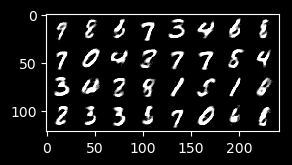

--------------------------------------------------------------
CVAE --- epoch_ 1


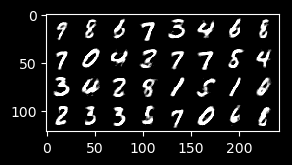

--------------------------------------------------------------
CVAE --- epoch_ 2


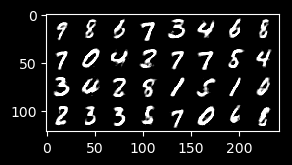

--------------------------------------------------------------


In [61]:

#【G任务】
print("--------------------CVAE 新做task G，生成随机sample的code对应图像---------------------")
for idx in [0,1,2]:
    print("CVAE --- epoch_",idx)
    recons_path = f'./results_CVAE/epoch_{idx}.png' 
    #【必须要带f，表示字符串中可以使用定义好的变量】
    Image = mpimg.imread(recons_path)
    plt.figure(figsize=(3, 4))
    plt.imshow(Image)
    plt.show()
    print('--------------------------------------------------------------')


# 2. 使⽤Convolution layer 实现AE，VAE，CVAE 重复以上的每⼀个任务